**Mounting Drive to Project Folder**

In [ ]:
###### Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing required Libraries**

In [ ]:
##### Installing Unidecode
!pip install Unidecode

In [ ]:
#### Importing required Libraries
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from nltk.corpus import words
import matplotlib.pyplot as plt
import unidecode
import nltk
import re

In [ ]:
#### Importing StopWords
nltk.download('stopwords')
stopwords =  set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Loading Datasets**

In [ ]:
##### Loading training and testing Data
df_train = pd.read_csv('/content/drive/MyDrive/B154_19CSE453_NLP/Project/train.csv',encoding='latin-1')
df_test = pd.read_csv('/content/drive/MyDrive/B154_19CSE453_NLP/Project/test.csv',encoding='latin-1')
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
### Dimesions of training dataset
df_train.shape

(41157, 6)

In [ ]:
#### Checking for null Values
df_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
#### Attributes Information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
### Drop unneccesary features
df_train = df_train.drop(columns='Location')

In [ ]:
### Review Dataset
df_train.head()

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
### Checking unique Sentiments
df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
### Label Encoding the Sentiment Feature
df_train['label'] = df_train.Sentiment.factorize()[0]

**This will rename the Sentiments into numbers**

**0 - Neutral**
**1 - Positive**
**2 - Extremely Negative**
**3 - Negative**
**4 - Extremely Positive**

In [ ]:
##### Review Dataset
df_train.head()

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment,label
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive,1
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,2


In [ ]:
##### Storing unique Sentiments into target category
target_category = df_train['Sentiment'].unique()
target_category

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

**Data Visualisation**


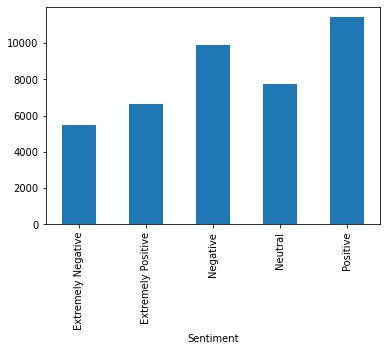

In [ ]:

df_train.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

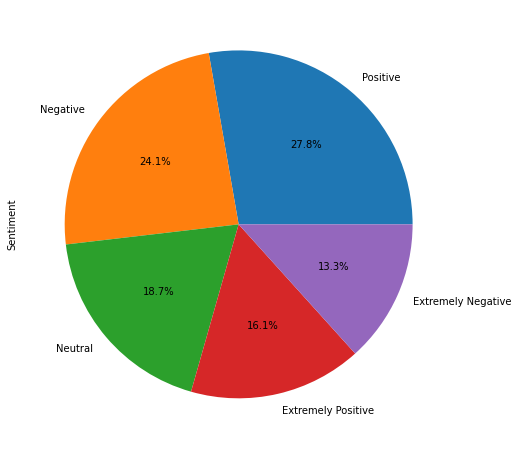

In [ ]:
df_train.Sentiment.value_counts().plot(kind='pie', y='label',figsize=(10,8),autopct='%1.1f%%')
plt.show()

In [ ]:
tweets = df_train.OriginalTweet
tweets.head(10)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

**Data Preprocessing**

In [ ]:
def processing(text): 

    #Convert Accented Characters(û -> u)
    text = unidecode.unidecode(text)

    #Tokenisation
    tokenized_text = word_tokenize(text)
￼
    #Stopwords Removal
    filtered_words = []
    for w in tokenized_text:
      if w not in stopwords:
        filtered_words.append(w)

    #Removing numbers and extra whitespaces using Regex
    pattern = '[a-zA-Z]'
    text = ''
    for i in filtered_words:
      if re.match(pattern,i):
        text += i+" "

    text = text.replace("'", "") 
        
    #lemmatization
    lemmatizer = WordNetLemmatizer()

    #Pos-Tagging
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])

    #stemming 
    stemmer= PorterStemmer()
    stem_input= nltk.word_tokenize(lem_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
           
    #remove single letters
    preprocessed_text = ' '.join( [w for w in stem_text.split() if len(w)>1] )
          
    return preprocessed_text

In [ ]:
###Apply Preprocessing on OriginalTweets
df_train['OriginalTweet']=df_train['OriginalTweet'].apply(processing)

In [ ]:
###OriginalTweets after preprocessing
tweets = df_train['OriginalTweet']
tweets.head()

0           menyrbi phil_gahan chrisitv http http http
1    advic talk neighbour famili exchang phone numb...
2    coronaviru australia woolworth give elderli di...
3    My food stock one empti pleas nt panic there w...
4    Me readi go supermarket covid19 outbreak not p...
Name: OriginalTweet, dtype: object

In [ ]:
## Loading targetFeature
sentiment = df_train.Sentiment

**Splitting Data into train and test sets**

In [ ]:
##Splitting Data
X_train, X_test, Y_train, Y_test = train_test_split(tweets,sentiment, test_size = 0.3, random_state = 60,shuffle=True)

print(len(X_train))
print(len(X_test))

28809
12348


**Model1 -  SGD Classifier**

In [ ]:
###Pipelining the Model
sgd = Pipeline([('tfidf', TfidfVectorizer()),('sgd', SGDClassifier())])

###Fit Data into the model
sgd.fit(X_train, Y_train)

##Prediction
test_predict = sgd.predict(X_test)

###Accuracy
train_accuracy = round(sgd.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("SGD Train Accuracy Score : {}% ".format(train_accuracy ))
print("SGD Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

SGD Train Accuracy Score : 77% 
SGD Test Accuracy Score  : 54% 

                    precision    recall  f1-score   support

           Neutral       0.77      0.52      0.62      2488
          Positive       0.81      0.52      0.63      3048
Extremely Negative       0.32      0.54      0.40      1822
          Negative       0.74      0.56      0.64      3062
Extremely Positive       0.31      0.54      0.39      1928

          accuracy                           0.54     12348
         macro avg       0.59      0.54      0.54     12348
      weighted avg       0.64      0.54      0.56     12348



In [ ]:
#### Reviewing Test Dataset
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
### Applying Model on Test Dataset
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(processing)
tweet = df_test['OriginalTweet']
y_predict = sgd.predict(tweet)

In [ ]:
## Loading Target Feature
test_sentiments = df_test['Sentiment']

In [ ]:
###Test Data Accuracy
test_accuracy =round(accuracy_score(test_sentiments, y_predict)*100)
print("SGD Classifier Test Accuracy Score  : {}% ".format(test_accuracy ))

SGD Classifier Test Accuracy Score  : 52% 


**Model2 -  RandomForest Classifier**

In [ ]:
###Pipelining the Model
rfc = Pipeline([('tfidf', TfidfVectorizer()),('rfc', RandomForestClassifier())])

###Fit Data into the model
rfc.fit(X_train, Y_train)

##Prediction
test_predict = rfc.predict(X_test)

###Accuracy
train_accuracy = round(rfc.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("RFC Train Accuracy Score : {}% ".format(train_accuracy ))
print("RFC Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

RFC Train Accuracy Score : 100% 
RFC Test Accuracy Score  : 53% 

                    precision    recall  f1-score   support

           Neutral       0.37      0.67      0.48       932
          Positive       0.37      0.69      0.48      1053
Extremely Negative       0.49      0.50      0.49      3021
          Negative       0.72      0.58      0.64      2856
Extremely Positive       0.61      0.45      0.52      4486

          accuracy                           0.53     12348
         macro avg       0.51      0.58      0.52     12348
      weighted avg       0.57      0.53      0.54     12348



In [ ]:
### Prediction on Test Dataset
tweet = df_test['OriginalTweet']
y_predict = rfc.predict(tweet)

In [ ]:
###Accuracy
test_accuracy =round(accuracy_score(test_sentiments, y_predict)*100)
print("RFC Classifier Test Accuracy Score  : {}% ".format(test_accuracy ))

RFC Classifier Test Accuracy Score  : 48% 


**Model3 -  Logistic Regression**

In [ ]:
###Pipelining the Model
lr = Pipeline([('tfidf', TfidfVectorizer()),('lr', LogisticRegression())])

###Fit Data into the model
lr.fit(X_train, Y_train)

##Prediction
test_predict = lr.predict(X_test)

###Accuracy
train_accuracy = round(lr.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("LR Train Accuracy Score : {}% ".format(train_accuracy ))
print("LR Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Train Accuracy Score : 79% 
LR Test Accuracy Score  : 58% 

                    precision    recall  f1-score   support

           Neutral       0.51      0.65      0.57      1324
          Positive       0.55      0.67      0.60      1602
Extremely Negative       0.52      0.53      0.52      3068
          Negative       0.65      0.65      0.65      2300
Extremely Positive       0.63      0.51      0.56      4054

          accuracy                           0.58     12348
         macro avg       0.57      0.60      0.58     12348
      weighted avg       0.58      0.58      0.58     12348



In [ ]:
### Prediction on Test Dataset
tweet = df_test['OriginalTweet']
y_predict = lr.predict(tweet)

In [ ]:
###Test Data Accuracy
test_accuracy =round(accuracy_score(test_sentiments, y_predict)*100)
print("LR Classifier Test Accuracy Score  : {}% ".format(test_accuracy ))

LR Classifier Test Accuracy Score  : 55% 
